In [1]:
import sys 
sys.path.append("../")

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score
import umap
import sklearn
import pandas as pd 
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.models import Word2Vec
import numpy as np
import nltk
import umap.plot as up
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
import gensim

from itertools import chain

from core.utils import (find_non_numerical_columns,categorize_columns,evaluate_cross_validation,
                   convert_df_to_numeric_df,scale_columns,evaluate_model,objective_xgb,preprocess_text)
%load_ext autoreload
%autoreload 2

/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-pac

# Exploratory analysis

In [2]:
df = pd.read_excel("../data/assignement.xlsx")
target = df["Exited"]

In [3]:
true_sentence = [ sentence for sentence in df["CustomerFeedback"].values if isinstance(sentence,str)] 
true_sentence_index = [ i for i,sentence in enumerate(df["CustomerFeedback"].values) if isinstance(sentence,str)]
for position,index in enumerate(true_sentence_index) :
    assert df["CustomerFeedback"].iloc[index] == true_sentence[position]

In [4]:
corpus = [ preprocess_text(text) for text in true_sentence]
corpus = list(chain.from_iterable(corpus))

In [13]:
full_string = " ".join(corpus)

In [14]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

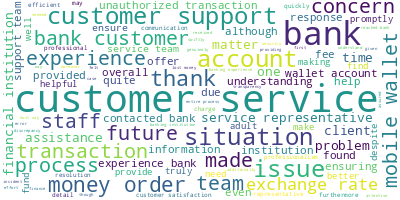

In [15]:
wordcloud.generate(full_string)
wordcloud.to_image()

# LDA analysis

### Compute dictionary and frequencies

In [34]:
from gensim.corpora import Dictionary
id2word = Dictionary([corpus])
bag_of_word = [id2word.doc2bow(text) for text in [corpus]]

In [47]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=bag_of_word,
                                       id2word=id2word,
                                       num_topics=num_topics)


In [48]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

In [49]:
pyLDAvis.enable_notebook()

In [50]:
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))

In [51]:
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, bag_of_word, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.001675 -0.000496       1        1  34.372464
2     -0.001461  0.001228       2        1  28.630182
0     -0.000736 -0.001740       3        1  27.747187
4      0.001215  0.002074       4        1   8.627474
3      0.002657 -0.001067       5        1   0.622693, topic_info=            Term         Freq        Total Category  logprob  loglift
630         bank  5958.000000  5958.000000  Default  30.0000  30.0000
1439    customer  4975.000000  4975.000000  Default  29.0000  29.0000
5271     service  3744.000000  3744.000000  Default  28.0000  28.0000
117      account  3254.000000  3254.000000  Default  27.0000  27.0000
3314       issue  2474.000000  2474.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2647      future     4.262951   712.975693   Topic5  -5.7871  -0.0406
4711    recently     4.905730  1083.295946   Topic5  -5.6467  -0.3185
518   assistance     4.415919   812.971808   Topic5  -5.7519  -0.1366
6043       trust     4.338017   784.960985   Topic5  -5.7697  -0.1193
3490        like     4.275069   746.083733   Topic5  -5.7843  -0.0832

[438 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
51        1  0.567140            59
51        2  0.567140            59
81        1  0.563610        absurd
111       1  0.567404  accomplished
111       2  0.567404  accomplished
...     ...       ...           ...
6586      5  0.005552         would
6613      1  0.450900     yesterday
6613      2  0.225450     yesterday
6613      3  0.257657     yesterday
6613      4  0.064414     yesterday

[1128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 4])

# Using a dictionnary based approach

In [52]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/gregoryscafarto/nltk_data...


True

In [53]:
dictionary_based_model = SentimentIntensityAnalyzer()
corpus_by_user = [ nltk.sent_tokenize(text) for text in true_sentence]

Text(0.5, 1.0, 'Distribution of positive scores')

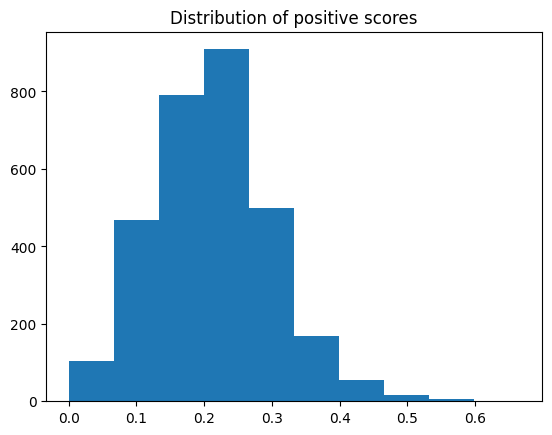

In [60]:
sentiments_pos_score = [[dictionary_based_model.polarity_scores(sentence)["pos"] for sentence in corpus_by_user[j] ] for j in range(len(true_sentence))]
average_sentiments_pos_score = [np.mean(score) for score in sentiments_pos_score]
fig = plt.hist(average_sentiments_pos_score)
plt.title("Distribution of positive scores")

Text(0.5, 1.0, 'Distribution of negative scores')

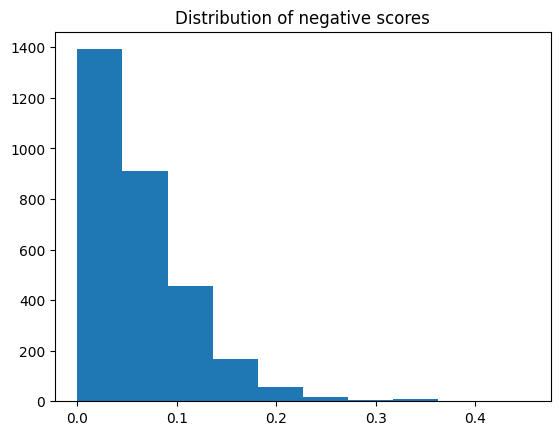

In [61]:
sentiments_neg_score = [[dictionary_based_model.polarity_scores(sentence)["neg"] for sentence in corpus_by_user[j] ] for j in range(len(true_sentence))]
average_sentiments_neg_score = [np.mean(score) for score in sentiments_neg_score]
fig  = plt.hist(average_sentiments_neg_score)
plt.title("Distribution of negative scores")

Text(0.5, 1.0, 'Sentiment score distribution')

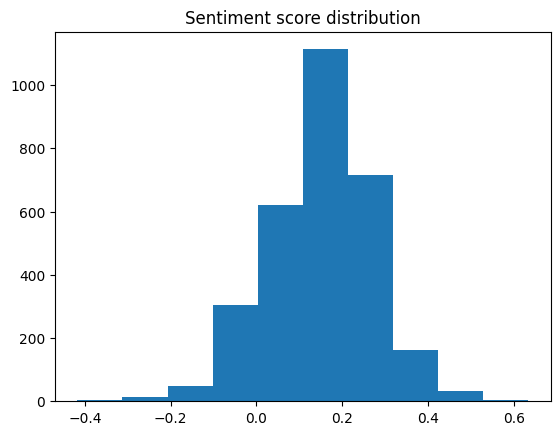

In [62]:
average_score = [ pos - neg for pos,neg in zip(average_sentiments_pos_score,average_sentiments_neg_score)]
fig = plt.hist(average_score)
plt.title("Sentiment score distribution")

In [158]:
labels = []
for i,scores in enumerate(average_score) :
    if scores > 0.1 :
        labels.append(2)
    elif scores < -0.1 :
        labels.append(1)
    else :
        labels.append(0)
df['SentimentsDictionnary'] = [-1 for _ in range(len(df))]
for position,index in enumerate(true_sentence_index):
    df.at[index,'SentimentsDictionnary'] = labels[position]

In [160]:
for index in true_sentence_index :
    assert df["CustomerFeedback"].iloc[index] is not None 


##### Some examples 

In [86]:
import  random 
number_feedback_to_plot = 5
print("POSITIVE reviews")
for i in range(number_feedback_to_plot) :
    positive_review_index = random.choice(np.where(np.array(labels)==2)[0])
    print(true_sentence[positive_review_index])
print("=========")
print("NEGATIVE reviews")
for i in range(number_feedback_to_plot) :
    positive_review_index = random.choice(np.where(np.array(labels)==1)[0])
    print(true_sentence[positive_review_index])

POSITIVE reviews
My initial experience with this bank had me quite concerned, as the money I had deposited was not available in my account when promised. Naturally, I found this to be a great inconvenience as I was counting on those funds. However, the moment I reached out to their customer support to discuss this matter, my concerns were put to rest.

I spoke to an extremely patient and attentive representative who walked me through the situation. It turned out there was a minor hiccup that delayed the transfer, and she assured me that the funds would become available within the day. True to her word, my account balance was updated to reflect my deposit, and the issue was fully resolved.

What sets this bank apart, in my experience, is their prompt, efficient, and courteous response to concerns. The fact that they rectify matters so diligently provides me with the assurance and confidence that I am a valued client. Such proactive steps to maintain a high standard of service will no do

# Doc2vec approach

In [10]:
#corpus = [ preprocess_text(text) for text in true_sentence]
documents = [ preprocess_text(x) for x in true_sentence]

In [21]:
size = 75
window = 100
min_count = 5
sg = 1
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
docu = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]
w2v_model = Doc2Vec(docu,min_count=min_count,vector_size=size,workers=4,window=window)

In [22]:
words_embeddings = np.vstack([w2v_model.wv[word] for word  in w2v_model.wv.index_to_key])

In [23]:
vectorize_doc = [[w2v_model.wv[word] for word in sentence if word in w2v_model.wv.index_to_key] for sentence in documents]

In [24]:
vectorize_sentence = [np.mean(sentence, axis=0) for sentence in vectorize_doc if not isinstance(sentence, np.ndarray) and len(sentence)> 0] 

In [25]:
for i in range(len(vectorize_sentence)) :
    assert(len(vectorize_sentence[i])) == size

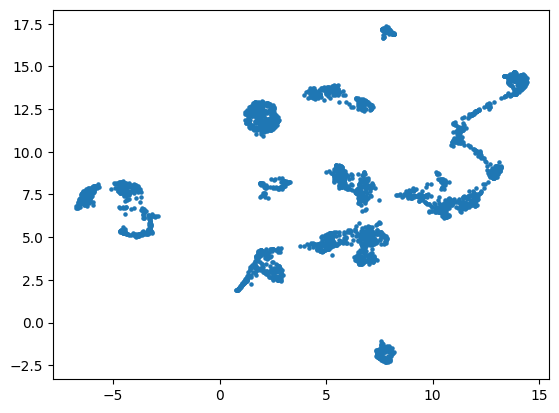

In [26]:
import umap
reducer = umap.UMAP()
#embedding = reducer.fit_transform(vectorize_sentence)
embedding = reducer.fit_transform(vectorize_sentence)
embedding_words = reducer.transform(words_embeddings)
plt.scatter(embedding[:, 0], embedding[:, 1],s=5)

In [29]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1, min_samples=100).fit(embedding)
centroids = np.array([np.vstack(embedding[np.where(clustering.labels_==label)]).mean(axis=0) for label in np.unique(clustering.labels_)])

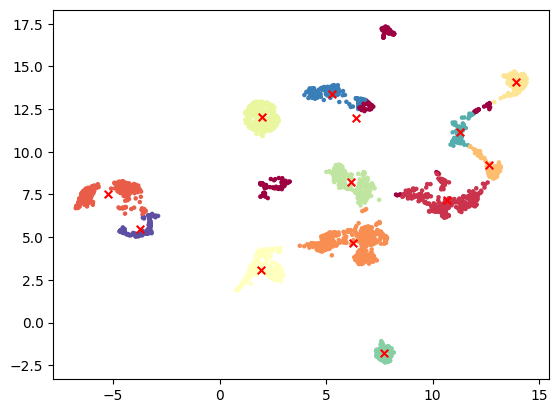

In [30]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=clustering.labels_, cmap='Spectral', s=5)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=30,marker="x")

In [31]:
dic_topics = {}
for topic in np.unique(clustering.labels_) :
    dic_topic = {}
    similarity  = np.matmul(embedding_words ,centroids[topic,:].reshape(1,-1).T).mean(axis=1)
    ordered_similarity = np.argsort(similarity)
    dic_topic.update({"centroid" : ordered_similarity[0] })
    dic_topic.update({"top k vectors" : ordered_similarity[1:10] })
    dic_topics.update({"topic_"+str(topic) : dic_topic })

In [32]:
for topic in  np.unique(clustering.labels_)  :
    print(w2v_model.wv.index_to_key[dic_topics["topic_"+str(topic) ]["centroid"]])
    print([ w2v_model.wv.index_to_key[word] for word in dic_topics["topic_"+str(topic)]["top k vectors"]])

easy
['adding', 'opening', 'making', 'app', 'interface', 'free', 'friendly', 'platform', 'mobile']
using
['track', 'use', 'interface', 'hassle', 'setting', 'app', 'user', 'platform', 'opening']
order
['step', 'losing', 'assistance', 'money', 'guidance', 'showed', 'replaced', 'anxious', 'handle']
easy
['adding', 'opening', 'making', 'app', 'interface', 'free', 'friendly', 'platform', 'mobile']
order
['step', 'losing', 'assistance', 'money', 'guidance', 'showed', 'replaced', 'anxious', 'handle']
order
['step', 'losing', 'assistance', 'money', 'guidance', 'showed', 'replaced', 'anxious', 'handle']
step
['order', 'losing', 'assistance', 'money', 'guidance', 'handle', 'intended', 'unfortunate', 'stolen']
process
['simple', 'manage', 'application', 'overall', 'via', 'straightforward', 'closing', 'using', 'instruction']
interface
['easy', 'using', 'opening', 'app', 'adding', 'platform', 'hassle', 'user', 'managing']
step
['order', 'losing', 'assistance', 'money', 'guidance', 'intended', 'hand